In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import jenkspy
import branca.colormap as cm
import re

#Extract the inflows and the outflows of each state from the flow data using rootsid as id 
# Specify the directory containing the CSV files
directory_path = 'flow_data'

# Loop through each file in the directory
for file_name in os.listdir(directory_path):
    try:
        # Check if the file is a CSV
        if file_name.endswith('.csv'):
            # Construct the full file path
            file_path = os.path.join(directory_path, file_name)

            # Read the CSV file
            df = pd.read_csv(file_path)

            # Get unique Ids 
            states = set(df['origState']).union(set(df['destState']))

            # Calculate outflows volumes from familycnt column 
            outflows_df = df.groupby('origState')['familycnt'].sum().reset_index()
            outflows_df.rename(columns={'origState': 'rootsid', 'familycnt': 'Outflows'}, inplace=True)

            # Calculate inflows volumes from familycnt column 
            inflows_df = df.groupby('destState')['familycnt'].sum().reset_index()
            inflows_df.rename(columns={'destState': 'rootsid', 'familycnt': 'Inflows'}, inplace=True)

            # Create a DataFrame with all State IDs
            states_df = pd.DataFrame({'rootsid': list(states)})

            # Merge all States with outflows and inflows DataFrames
            merged_df = pd.merge(states_df, outflows_df, on='rootsid', how='left')
            merged_df = pd.merge(merged_df, inflows_df, on='rootsid', how='left')

            # Fill NaN values with 0 for Outflows and Inflows
            merged_df['Outflows'] = merged_df['Outflows'].fillna(0)
            merged_df['Inflows'] = merged_df['Inflows'].fillna(0)

            # Filter out State IDs not between 101 and 158
            merged_df = merged_df[(merged_df['rootsid'] >= 101) & (merged_df['rootsid'] <= 158)]

            # Sort the DataFrame by State ID in ascending order
            merged_df.sort_values(by='rootsid', inplace=True)

            # Reset the index after sorting
            merged_df.reset_index(drop=True, inplace=True)

            # Construct the output file path
            output_file_path = os.path.join(directory_path, f'processed_{file_name}')

            # Save the results to a new CSV file
            merged_df.to_csv(output_file_path, index=False)

            print(f"Processed data saved to {output_file_path}")
    except pd.errors.EmptyDataError:
        print(f"No data in file {file_name}, skipped.")
    except pd.errors.ParserError:
        print(f"Error parsing file {file_name}, skipped.")
    except Exception as e:
        print(f"An error occurred processing {file_name}: {e}")



Processed data saved to flow_data\processed_childladder_flows_1800.csv
Processed data saved to flow_data\processed_childladder_flows_1801.csv
Processed data saved to flow_data\processed_childladder_flows_1802.csv
Processed data saved to flow_data\processed_childladder_flows_1803.csv
Processed data saved to flow_data\processed_childladder_flows_1804.csv
Processed data saved to flow_data\processed_childladder_flows_1805.csv
Processed data saved to flow_data\processed_childladder_flows_1806.csv
Processed data saved to flow_data\processed_childladder_flows_1807.csv
Processed data saved to flow_data\processed_childladder_flows_1808.csv
Processed data saved to flow_data\processed_childladder_flows_1809.csv
Processed data saved to flow_data\processed_childladder_flows_1810.csv
Processed data saved to flow_data\processed_childladder_flows_1811.csv
Processed data saved to flow_data\processed_childladder_flows_1812.csv
Processed data saved to flow_data\processed_childladder_flows_1813.csv
Proces

In [4]:
#Using the output of the previous code, perform simple averages to smoothen the data. This uses a 5 year window average to interpolate values 
directory_path = 'flow_data'

# Define the window size for the moving average
window_size = 5

# Define the full range of rootsid values
all_rootsid = range(101, 159)  # 101 to 158 inclusive

# Loop through each processed file in the directory
for file_name in os.listdir(directory_path):
    try:
        if file_name.startswith('processed_') and file_name.endswith('.csv'):
            file_path = os.path.join(directory_path, file_name)

            # Read the CSV file
            df = pd.read_csv(file_path)

            # Ensure all rootsid are present by creating a template DataFrame with all rootsid values
            # and merging it with the existing data, filling missing values explicitly with 0
            template_df = pd.DataFrame({'rootsid': all_rootsid})
            df = pd.merge(template_df, df, on='rootsid', how='left').fillna(0)  # Fill all NaNs with 0

            # Calculate the moving averages for Outflows and Inflows
            df['MA_Outflows'] = np.ceil(df['Outflows'].rolling(window=window_size, min_periods=1).mean())
            df['MA_Inflows'] = np.ceil(df['Inflows'].rolling(window=window_size, min_periods=1).mean())

            # Save the results to a new CSV file, ensuring not to overwrite the original processed files
            output_file_path = os.path.join(directory_path, f'avg_{file_name}')
            df.to_csv(output_file_path, index=False)

            print(f"Moving averages calculated and saved to {output_file_path}")
    except Exception as e:
        print(f"An error occurred while processing {file_name}: {e}")


Moving averages calculated and saved to flow_data\avg_processed_childladder_flows_1800.csv
Moving averages calculated and saved to flow_data\avg_processed_childladder_flows_1801.csv
Moving averages calculated and saved to flow_data\avg_processed_childladder_flows_1802.csv
Moving averages calculated and saved to flow_data\avg_processed_childladder_flows_1803.csv
Moving averages calculated and saved to flow_data\avg_processed_childladder_flows_1804.csv
Moving averages calculated and saved to flow_data\avg_processed_childladder_flows_1805.csv
Moving averages calculated and saved to flow_data\avg_processed_childladder_flows_1806.csv
Moving averages calculated and saved to flow_data\avg_processed_childladder_flows_1807.csv
Moving averages calculated and saved to flow_data\avg_processed_childladder_flows_1808.csv
Moving averages calculated and saved to flow_data\avg_processed_childladder_flows_1809.csv
Moving averages calculated and saved to flow_data\avg_processed_childladder_flows_1810.csv

In [5]:
#gets the year from the name of the file and creates a year field with this data and calculate the netflow ratio (Migration efficiency).
# Define the directory path that contains the processed files
directory_path = 'flow_data'

# Loop through each processed file in the directory
for file_name in os.listdir(directory_path):
    try:
        if file_name.startswith('avg_processed_') and file_name.endswith('.csv'):
            file_path = os.path.join(directory_path, file_name)

            # Extract the year from the file name using regular expression
            # This regex captures four digits at the end of the filename just before '.csv'
            match = re.search(r'_(\d{4}).csv$', file_name)
            if match:
                year = int(match.group(1))  # Convert the extracted year to an integer
            else:
                print(f"No year found in the file name {file_name}. Skipping this file.")
                continue  # Skip files where no year is found

            # Read the CSV file
            df = pd.read_csv(file_path)

            # Add a new column 'year' to the DataFrame
            df['year'] = year

            # Calculate the netflow ratio
            df['Netflow_Ratio'] = (df['MA_Inflows'] - df['MA_Outflows']) / (df['MA_Inflows'] + df['MA_Outflows'] + 1e-10)
            df['Netflow_Ratio'] = df['Netflow_Ratio'].round(2)

            # Save the results to a new CSV file
            output_file_path = os.path.join(directory_path, f'Net_{file_name}')
            df.to_csv(output_file_path, index=False)

            print(f"Netflow Ratio calculated and saved to {output_file_path} with the year {year}")
    except Exception as e:
        print(f"An error occurred while processing {file_name}: {e}")



Netflow Ratio calculated and saved to flow_data\Net_avg_processed_childladder_flows_1800.csv with the year 1800
Netflow Ratio calculated and saved to flow_data\Net_avg_processed_childladder_flows_1801.csv with the year 1801
Netflow Ratio calculated and saved to flow_data\Net_avg_processed_childladder_flows_1802.csv with the year 1802
Netflow Ratio calculated and saved to flow_data\Net_avg_processed_childladder_flows_1803.csv with the year 1803
Netflow Ratio calculated and saved to flow_data\Net_avg_processed_childladder_flows_1804.csv with the year 1804
Netflow Ratio calculated and saved to flow_data\Net_avg_processed_childladder_flows_1805.csv with the year 1805
Netflow Ratio calculated and saved to flow_data\Net_avg_processed_childladder_flows_1806.csv with the year 1806
Netflow Ratio calculated and saved to flow_data\Net_avg_processed_childladder_flows_1807.csv with the year 1807
Netflow Ratio calculated and saved to flow_data\Net_avg_processed_childladder_flows_1808.csv with the ye

In [6]:
#Combine the output of the previous code to one single dataframe or csv
# Define the directory path that contains the processed files
directory_path = 'flow_data'

# Initialize an empty DataFrame to store all combined data
all_data = pd.DataFrame()

# Loop through each file in the directory
for file_name in os.listdir(directory_path):
    # Check if the file is one of the output netflow ratio files
    if file_name.startswith('Net_avg_processed_') and file_name.endswith('.csv'):
        file_path = os.path.join(directory_path, file_name)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Append the dataframe to the all_data DataFrame
        all_data = pd.concat([all_data, df], ignore_index=True)

# Save the combined data to a new CSV file
combined_output_path = os.path.join(directory_path, 'migration.csv')
all_data.to_csv(combined_output_path, index=False)

print(f"All data combined and saved to {combined_output_path}")


All data combined and saved to flow_data\migration.csv


In [8]:
# Get the state names from the geojson and populated the migration data with the correponding name, join through the rootsid 
# Load both CSV files
df1 = pd.read_csv('flow_data\migration.csv')
df2 = pd.read_csv('statename.csv')

# Create a dictionary to map rootsid to name from the second dataframe
name_map = pd.Series(df2.name.values, index=df2.rootsid).to_dict()

# Map the names to the first dataframe using the map
df1['name'] = df1['rootsid'].map(name_map)

# Save the updated dataframe to a new CSV file
df1.to_csv('Migration.csv', index=False)

Current Working Directory: c:\Users\USER\Desktop\geoproj


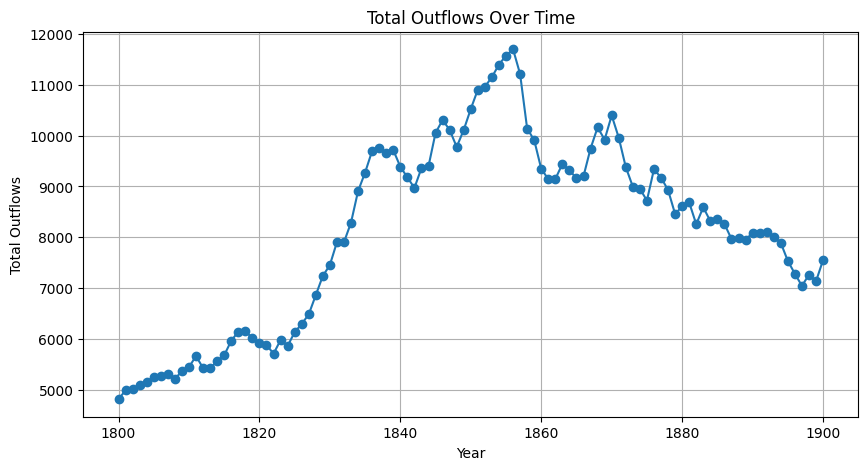

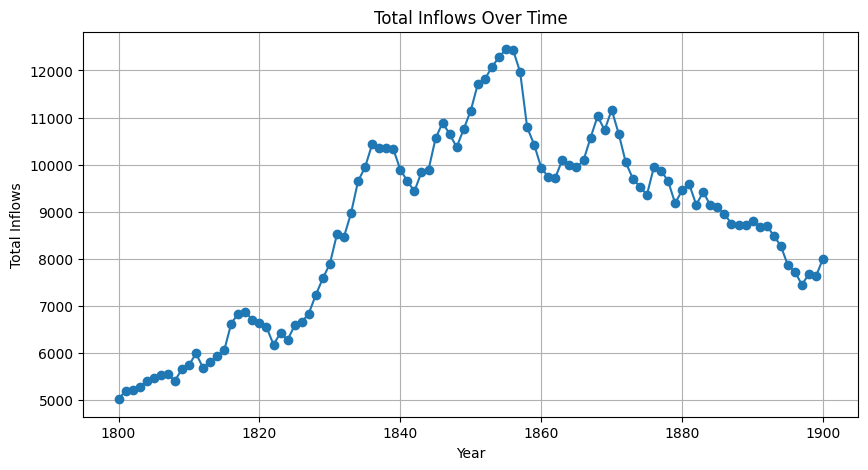

In [9]:
#Calculates the total inflows and outflows over time, plot a trend map to identify year with highest inflow and outflow 
# Print the current working directory

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current Working Directory:", current_directory)

# Load CSV data into a DataFrame
df = pd.read_csv('Migration.csv')

# Group data by year and sum the inflows
total_inflows = df.groupby('year')['MA_Inflows'].sum().reset_index()
# Group data by year and sum the Outflows
total_outflows = df.groupby('year')['MA_Outflows'].sum().reset_index()

# Plot the total outflows over time
plt.figure(figsize=(10, 5))
plt.plot(total_outflows['year'], total_outflows['MA_Outflows'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Outflows')
plt.title('Total Outflows Over Time')
plt.grid(True)
plt.show()

# Plot the total inflows over time
plt.figure(figsize=(10, 5))
plt.plot(total_inflows['year'], total_inflows['MA_Inflows'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Inflows')
plt.title('Total Inflows Over Time')
plt.grid(True)
plt.show()


In [11]:
#Arranges the state by the highest inflows and outflows 1800-1900
# Load CSV data into a DataFrame
df = pd.read_csv('Migration.csv')

# Aggregate data at the state level and sum the inflows and outflows
state_level_data = df.groupby('name')[['MA_Inflows', 'MA_Outflows']].sum().reset_index()

# Find the top 5 states with the highest inflows
top_inflow_states = state_level_data.nlargest(5, 'MA_Inflows')

# Find the top 5 states with the highest outflows
top_outflow_states = state_level_data.nlargest(5, 'MA_Outflows')

print("Top 5 states with the highest inflows:")
for index, state in top_inflow_states.iterrows():
    print(f"State: {state['name']}, Inflows: {state['MA_Inflows']}")

print("\nTop 5 states with the highest outflows:")
for index, state in top_outflow_states.iterrows():
    print(f"State: {state['name']}, Outflows: {state['MA_Outflows']}")


Top 5 states with the highest inflows:
State: Kentucky, Inflows: 43289.0
State: Kansas, Inflows: 37252.0
State: Louisiana, Inflows: 33437.0
State: Iowa, Inflows: 31335.0
State: Alabama, Inflows: 27319.0

Top 5 states with the highest outflows:
State: Kentucky, Outflows: 37357.0
State: Louisiana, Outflows: 28889.0
State: Kansas, Outflows: 28589.0
State: Oklahoma, Outflows: 27036.0
State: Alabama, Outflows: 26414.0


In [12]:
#statistics
# Assuming 'df' is your DataFrame grouped by year with summed inflows and outflows
print("Mean Inflows:", df['MA_Inflows'].mean())
print("Median Inflows:", df['MA_Inflows'].median())
print("Inflow Variance:", df['MA_Inflows'].var())
print("Inflow Standard Deviation:", df['MA_Inflows'].std())


# Assuming 'df' is your DataFrame grouped by year with summed inflows and outflows
print("Mean Outflows:", df['MA_Outflows'].mean())
print("Median Outflows:", df['MA_Outflows'].median())
print("Outflow Variance:", df['MA_Outflows'].var())
print("Outflow Standard Deviation:", df['MA_Outflows'].std())

# Correlation between Inflows and Outflows
print("Correlation between Inflows and Outflows:", df['MA_Inflows'].corr(df['MA_Outflows']))
# Calculate skewness of inflows
inflow_skewness = df['MA_Inflows'].skew()
print("Skewness of Inflows:", inflow_skewness)


Mean Inflows: 149.91669511778764
Median Inflows: 130.0
Inflow Variance: 12018.716979207356
Inflow Standard Deviation: 109.62990914530285
Mean Outflows: 139.97593035165585
Median Outflows: 120.0
Outflow Variance: 10034.50053033628
Outflow Standard Deviation: 100.1723541219646
Correlation between Inflows and Outflows: 0.8060074064718019
Skewness of Inflows: 1.6007257420604948


C:\Users\USER\AppData\Local\Temp\ipykernel_16768\985710526.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['centroids'] = merged_gdf.geometry.centroid


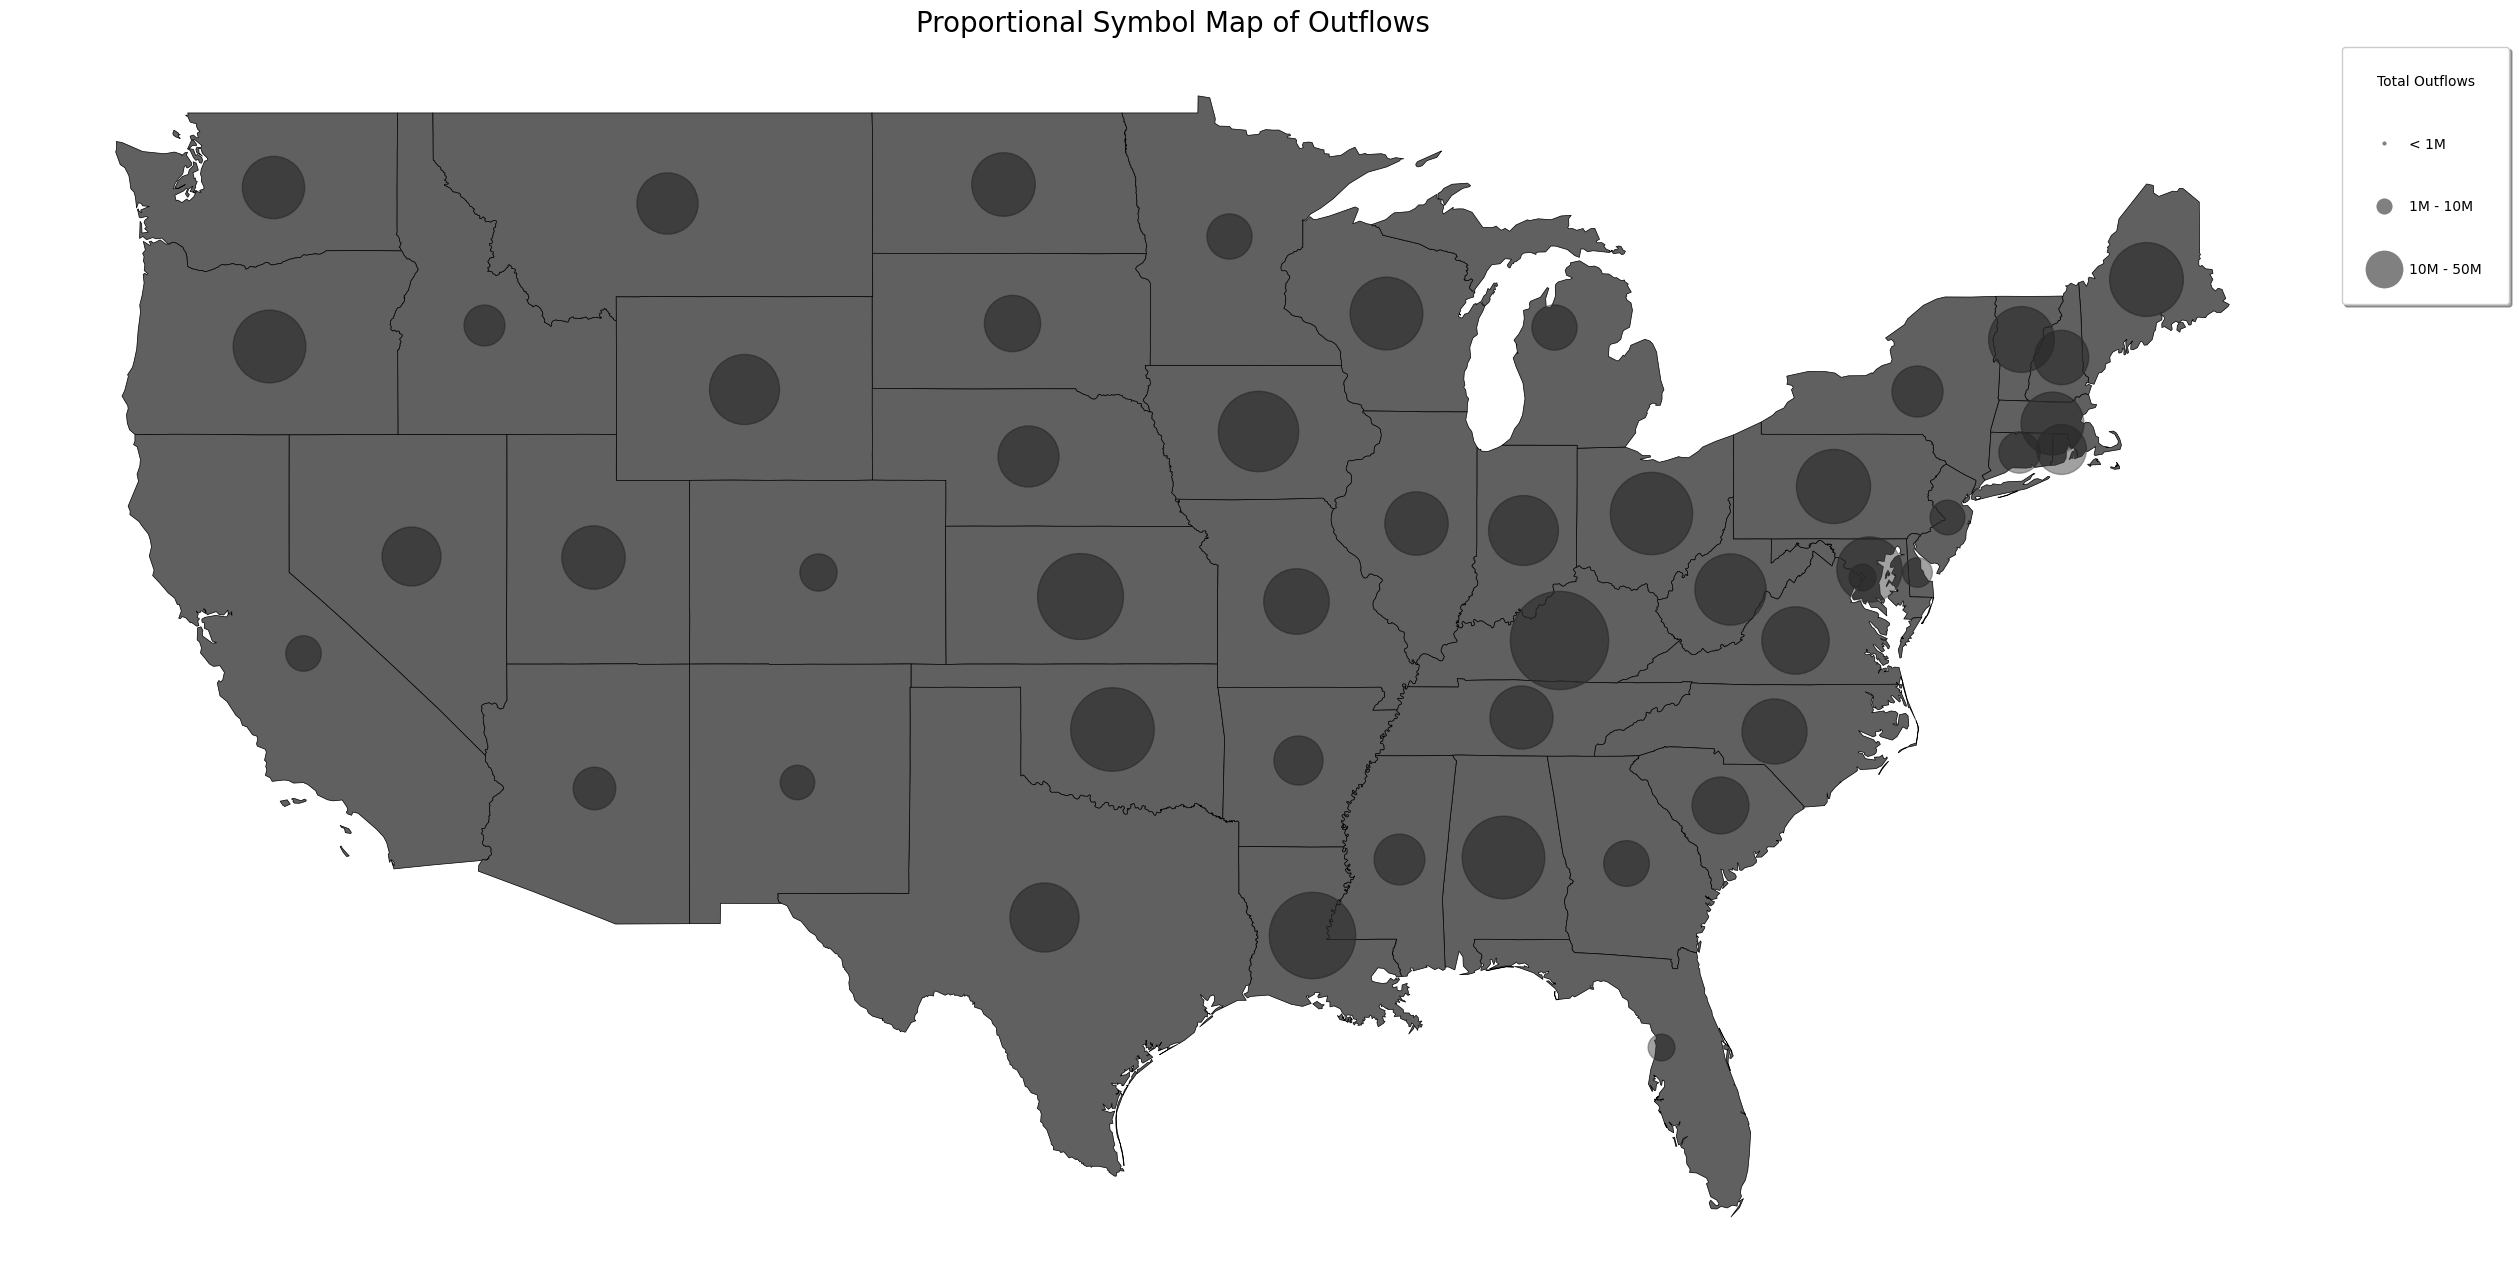

In [13]:
#proportional  maps of outflow
# Load the shapefile into a GeoDataFrame
shapefile_path = 'America.geojson'
geo_df = gpd.read_file(shapefile_path)

# Load additional data from a CSV file
csv_path =  'Migration.csv'
data_df = pd.read_csv(csv_path)

#Sum 'Outflows' for each region in the CSV data if needed
summed_data = data_df.groupby('rootsid')['MA_Outflows'].sum().reset_index()

# Merge the GeoDataFrame with the summed data DataFrame using a id (rootsid) key
merged_gdf = geo_df.merge(summed_data, on='rootsid')

# Calculate centroids for plotting proportional symbols
merged_gdf['centroids'] = merged_gdf.geometry.centroid

# Set up the plot
fig, ax = plt.subplots(figsize=(30, 20))
merged_gdf.plot(ax=ax, color='#f0f0f0', edgecolor='black', linewidth=0.5)  # Plot polygons

# Check the max outflows to adjust the size factor dynamically
max_outflow = merged_gdf['MA_Outflows'].max()
size_factor = 5000 / max_outflow  # Adjust this factor based on visual preferences and the data range

# Plot proportional symbols using 'outflows' summed values for the size
for idx, row in merged_gdf.iterrows():
    symbol_color = '#636363' 
    ax.scatter(row['centroids'].x, row['centroids'].y, s=row['MA_Outflows'] * size_factor, color=symbol_color, alpha=0.6)

# Plot proportional symbols
size_factor = 0.00005  # Adjust the size_factor to scale symbol sizes appropriately
markersize = merged_gdf['MA_Outflows'] * size_factor
merged_gdf.plot(ax=ax, marker='o', color='black', markersize=markersize, alpha=0.6)


# Add a nested legend
legend_sizes = [1000000, 10000000, 50000000]  # Custom ranges: <1M, 1M-10M, 10M-50M
legend_labels = ['< 1M', '1M - 10M', '10M - 50M']
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor='grey', markersize=np.sqrt(size * size_factor / np.pi)) for size, label in zip(legend_sizes, legend_labels)]
ax.legend(handles=legend_elements, title='Total Outflows', loc='upper left',
          bbox_to_anchor=(1, 1), fontsize='medium', frameon=True, shadow=True, borderpad=2.0,
          labelspacing=3.5)

# Set title
ax.set_title("Proportional Symbol Map of Outflows", fontsize=20)

# Remove axis
ax.set_axis_off()

plt.show()  #  

C:\Users\USER\AppData\Local\Temp\ipykernel_16768\3854544554.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['centroids'] = merged_gdf.geometry.centroid


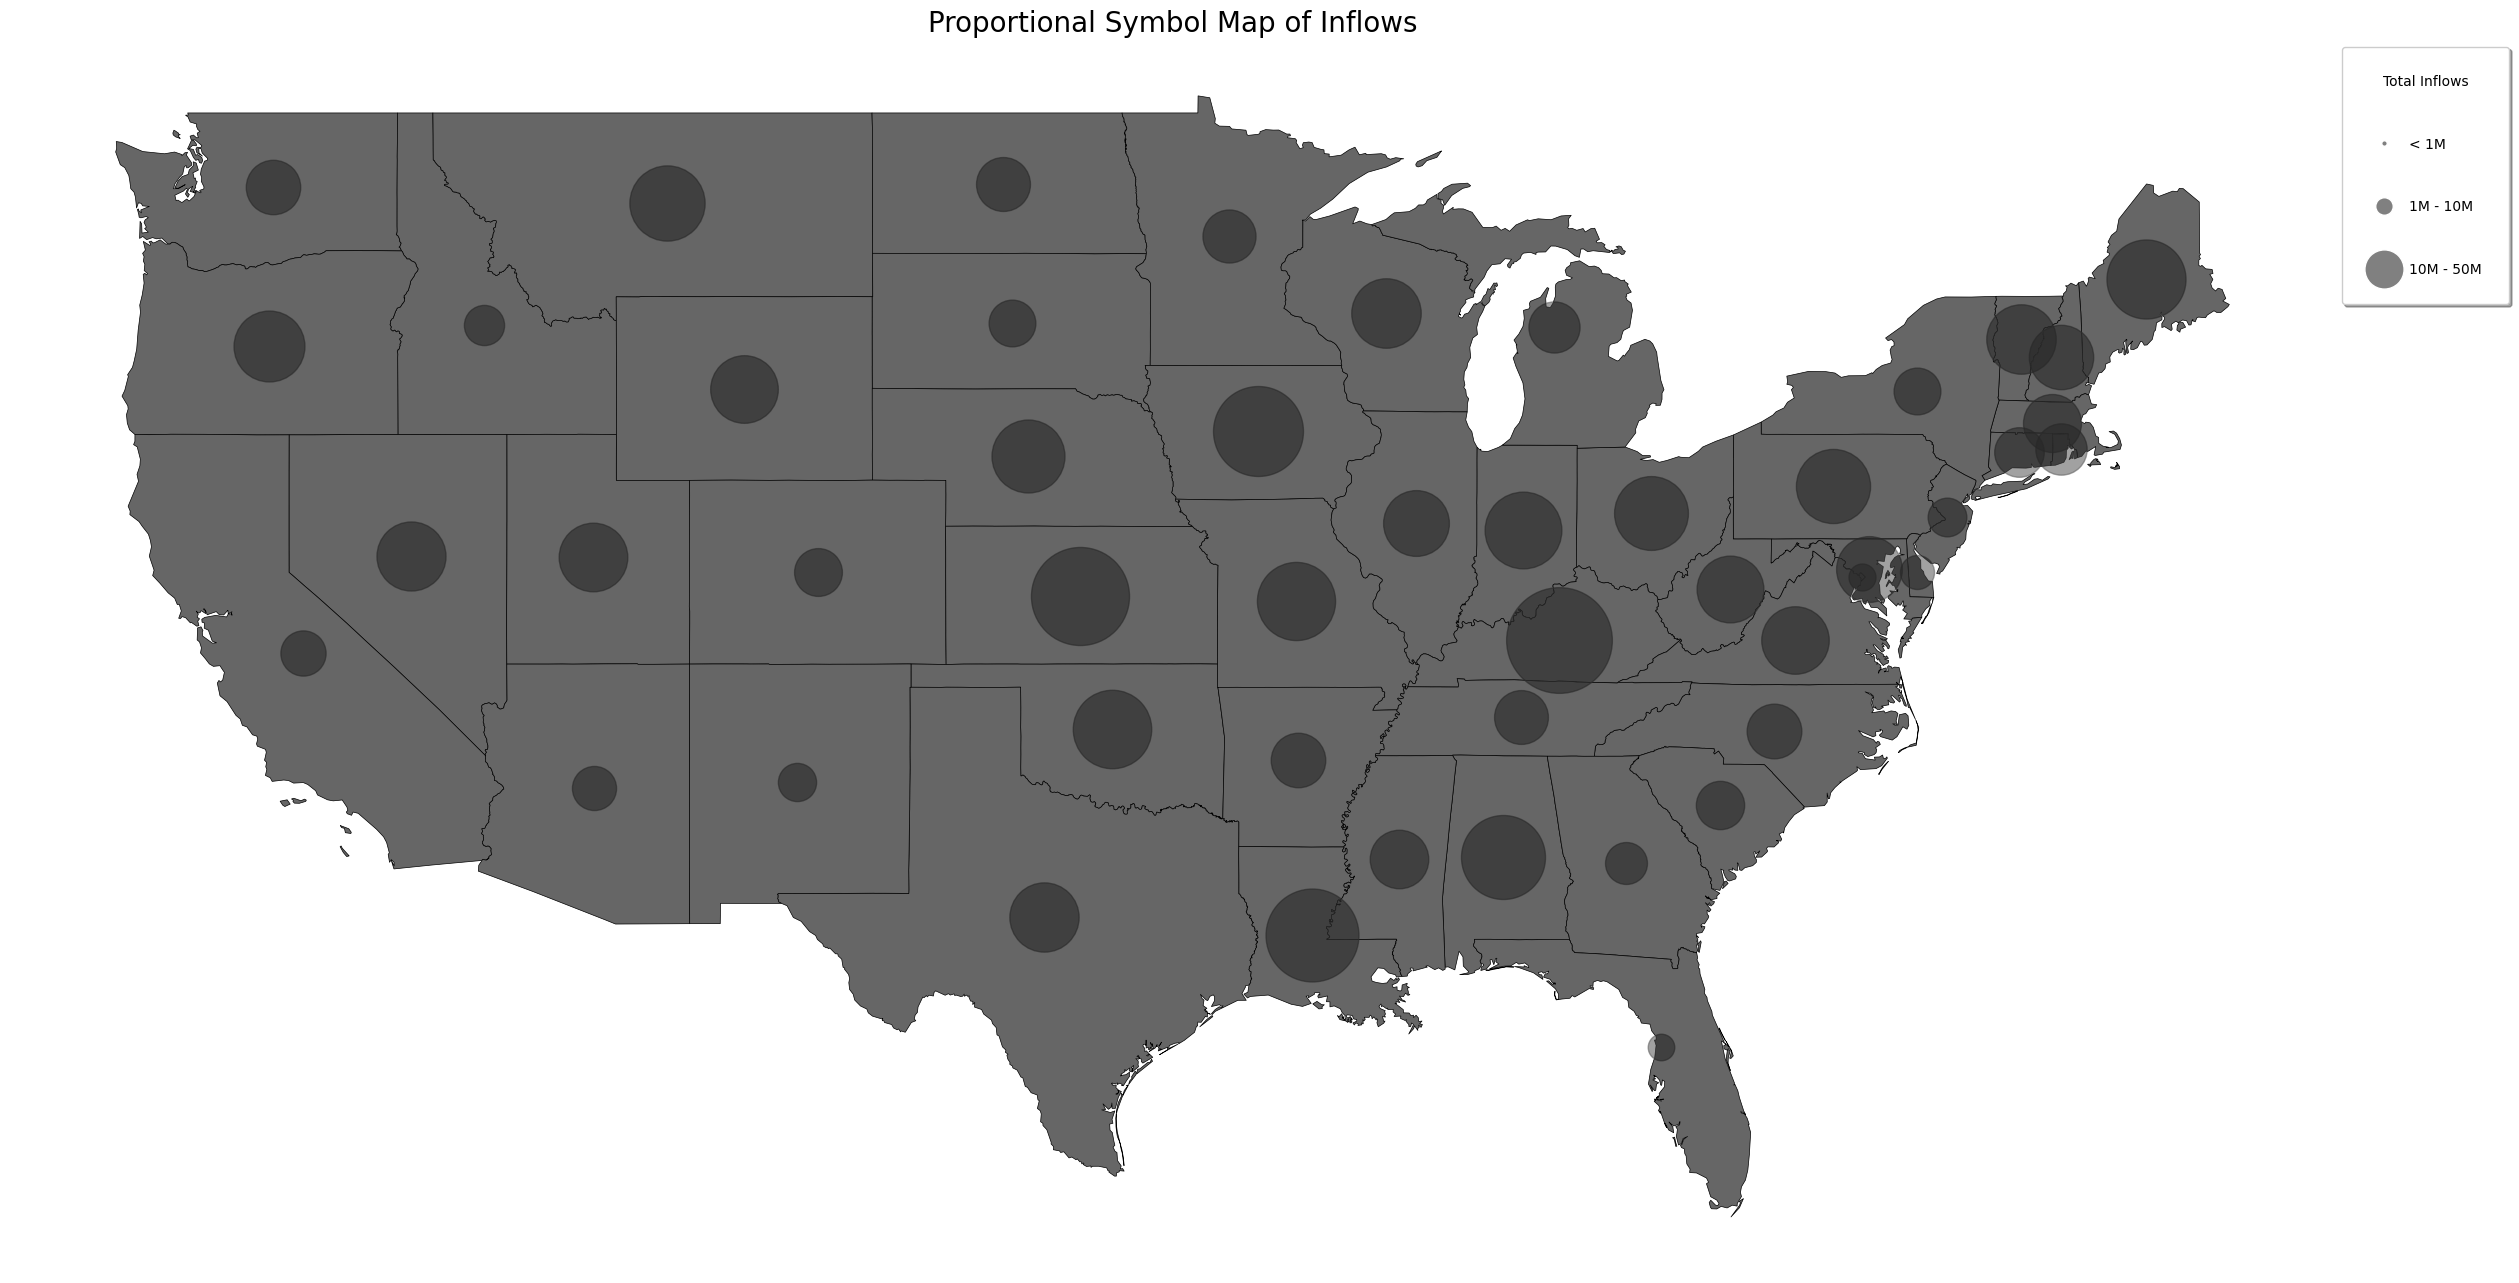

In [14]:
#poroportional maps of inflows
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

# Load the shapefile into a GeoDataFrame
shapefile_path = 'America.geojson'
geo_df = gpd.read_file(shapefile_path)

# Load additional data from a CSV file
csv_path = 'Migration.csv'
data_df = pd.read_csv(csv_path)

#Sum 'Outflows' for each region in the CSV data if needed
summed_data = data_df.groupby('rootsid')['MA_Inflows'].sum().reset_index()

# Merge the GeoDataFrame with the summed data DataFrame using a common key
# Ensure both geo_df and data_df contain a 'region_key' column that you merge on
merged_gdf = geo_df.merge(summed_data, on='rootsid')

# Calculate centroids for plotting proportional symbols
merged_gdf['centroids'] = merged_gdf.geometry.centroid

# Set up the plot
fig, ax = plt.subplots(figsize=(30, 20))
merged_gdf.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

# Check the max inflow to adjust the size factor dynamically
max_inflow = merged_gdf['MA_Inflows'].max()
size_factor = 5000 / max_outflow  # Adjust this factor based on visual preferences and the data range

# Plot proportional symbols using 'outflows' summed values for the size
for idx, row in merged_gdf.iterrows():
    symbol_color = '#636363'  # Default color, replace or modify as needed
    ax.scatter(row['centroids'].x, row['centroids'].y, s=row['MA_Inflows'] * size_factor, color=symbol_color, alpha=0.6)

# Plot proportional symbols
size_factor = 0.00005  # Adjust the size_factor to scale symbol sizes appropriately
markersize = merged_gdf['MA_Inflows'] * size_factor
merged_gdf.plot(ax=ax, marker='o', color='black', markersize=markersize, alpha=0.6)


# Add a nested legend
legend_sizes = [1000000, 10000000, 50000000]  # Custom ranges: <1M, 1M-10M, 10M-50M
legend_labels = ['< 1M', '1M - 10M', '10M - 50M']
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor='grey', markersize=np.sqrt(size * size_factor / np.pi)) for size, label in zip(legend_sizes, legend_labels)]
ax.legend(handles=legend_elements, title='Total Inflows', loc='upper left',
          bbox_to_anchor=(1, 1), fontsize='medium', frameon=True, shadow=True, borderpad=2.0,
          labelspacing=3.5)

# Set title
ax.set_title("Proportional Symbol Map of Inflows", fontsize=20)

# Remove axis
ax.set_axis_off()

plt.show()  # Display the

In [21]:
import geopandas as gpd
import pandas as pd
import folium
import jenkspy
from branca.colormap import linear

# Paths to the data
shapefile_path = 'America.geojson'
csv_path = 'Migration.csv'

try:
    # Attempt to load GeoJSON and CSV data
    geo_df = gpd.read_file(shapefile_path)
    data_df = pd.read_csv(csv_path)
except Exception as e:
    print(f"Error loading data: {e}")
    raise SystemExit("Failed to load shapefiles or CSV.")

try:
    # Convert year to string and filter rows
    data_df['year'] = data_df['year'].astype(str)
    data_df = data_df[data_df['year'] >= '1800']

    # Merge GeoDataFrame with DataFrame
    merged_gdf = geo_df.merge(data_df, on='rootsid', how='left')

    # Ensure there are enough unique values for Jenks breaks
    unique_values = merged_gdf['Netflow_Ratio'].dropna().unique()
    if len(unique_values) < 5:
        print("Not enough unique data points for 5 classes, reducing number of classes to", len(unique_values))
        n_classes = len(unique_values) if len(unique_values) > 1 else 1
    else:
        n_classes = 5

    # Calculate natural breaks using Jenks
    breaks = jenkspy.jenks_breaks(merged_gdf['Netflow_Ratio'].dropna(), n_classes=n_classes)

    # Setup colormap ensuring it can handle the actual number of breaks
    colormap = linear.RdYlBu_11.scale(min(breaks), max(breaks)).to_step(n=len(breaks)-1)
    colormap.caption = 'Netflow_Ratio'
except Exception as e:
    print(f"Error processing data: {e}")
    raise SystemExit("Failed during data processing.")

try:
    # Create map
    latitude = 39.8283
    longitude = -98.5795
    m = folium.Map(location=[latitude, longitude], zoom_start=5)

    # Define style function
    def style_function(feature):
        Netflow_Ratio = feature['properties']['Netflow_Ratio']
        return {
            'fillColor': colormap(Netflow_Ratio) if Netflow_Ratio is not None else 'transparent',
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.7
        }

    # Add layers
    for year in sorted(data_df['year'].unique()):
        year_data = merged_gdf[merged_gdf['year'] == year]
        fg = folium.FeatureGroup(name=f'Year {year}', show=False)
        folium.GeoJson(
            data=year_data,
            style_function=style_function,
            tooltip=folium.GeoJsonTooltip(
                fields=['rootsid', 'Netflow_Ratio'],
                aliases=['Roots ID:', 'Netflow_Ratio:'],
                localize=True
            )
        ).add_to(fg)
        fg.add_to(m)

    # Add LayerControl and colormap
    folium.LayerControl().add_to(m)
    colormap.add_to(m)

    # Save or display map
    m.save('migration.html')
except Exception as e:
    print(f"Error creating map: {e}")
    raise SystemExit("Failed during map creation.")
